In [1]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib notebook
%matplotlib widget

import sys
sys.path.append('/home/dtward/data/csh_data/emlddmm')
import emlddmm
import csv
from skimage.measure import marching_cubes
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from os.path import split,join,splitext

import pandas as pd
from scipy.stats import multivariate_normal
import os

In [2]:
ontology_name = '/nafs/dtward/dong/upenn_atlas/atlas_info_KimRef_FPbasedLabel_v2.7.csv'
seg_name = '/nafs/dtward/dong/upenn_atlas/UPenn_labels_reoriented_origin.vtk'

### Load UPenn ontology + Generate lists of descendents

In [3]:
xS,S,_,_ = emlddmm.read_data(seg_name)

In [4]:
# Transforms xS into a set of coordinates
XS = np.stack(np.meshgrid(*xS,indexing='ij'),-1)

In [5]:
# Center of mass of region 2294 (Definition of the 1st moment of the indicator function for label 2294)
# np.sum(XS*(S[0,...,None]==2294))/np.sum(S==2294)

In [6]:
parent_column = 7 # 8 for allen, 7 for yongsoo
label_column = 0 # 0 for both
shortname_column = 2# 3 for allen, 2 for yongsoo
longname_column = 1# 2 for allen, 1 for yongsoo
ontology = dict()
with open(ontology_name) as f:
    csvreader = csv.reader(f, delimiter=',', quotechar='"')
    count = 0
    for row in csvreader:        
        if count == 0:
            headers = row
            print(headers)
        else:
            if not row[parent_column]:
                parent = -1
            else:
                parent = int(row[parent_column])
            ontology[int(row[label_column])] = (row[shortname_column],row[longname_column],parent)
        count += 1


['\ufeffid', 'name', 'acronym', 'red', 'green', 'blue', 'structure_order', 'parent_id', 'parent_acronym']


In [7]:
# we need to find all the descendants of a given label
# first we'll get children
children = dict()
for o in ontology:
    parent = ontology[o][-1]
    if parent not in children:
        children[parent] = []
    children[parent].append(o)

In [8]:
# now we go from children to descendents
descendents = dict(children)
for o in descendents:
    for child in descendents[o]:
        if child in descendents: # if I don't do this i get a key error 0
            descendents[o].extend(descendents[child])
descendents[0] = []

In [9]:
descendents_and_self = dict(descendents)
for o in ontology:
    if o not in descendents_and_self:
        descendents_and_self[o] = [o]
    else:
        descendents_and_self[o].append(o)

In [10]:
ontology

{0: ('background', 'background', -1),
 997: ('root', 'root', -1),
 8: ('grey', 'Basic cell groups and regions', 997),
 567: ('CH', 'Cerebrum', 8),
 688: ('CTX', 'Cerebral cortex', 567),
 695: ('CTXpl', 'Cortical plate', 688),
 315: ('Isocortex', 'Isocortex', 695),
 184: ('FrA', 'Frontal association cortex', 315),
 68: ('FrA-1', 'Frontal pole, layer 1', 184),
 667: ('FrA-2/3', 'Frontal pole, layer 2/3', 184),
 2325: ('FrA-5', 'Frontal pole, layer 5', 184),
 500: ('M', 'motor cortex', 315),
 985: ('M1', 'Primary motor cortex', 500),
 320: ('M1-1', 'Primary motor cortex, layer 1', 985),
 943: ('M1-2/3', 'Primary motor cortex, layer 2/3', 985),
 648: ('M1-5', 'Primary motor cortex, layer 5', 985),
 844: ('M1-6a', 'Primary motor cortex, layer 6a', 985),
 882: ('M1-6b', 'Primary motor cortex, layer 6b', 985),
 2017: ('FrC3', 'Frontal cortex, area 3', 985),
 2334: ('FrC3-1', 'Frontal cortex, area 3, layer1', 2017),
 2335: ('FrC3-2/3', 'Frontal cortex, area 3, layer2/3', 2017),
 2336: ('FrC3-5

## Generate Boolean masks for CP, CPr (+CPre), CPi, CPc (+CPce)

In [11]:
# find all the descendents of Caudoputemen- rostral
# and caudoputemen rostral- extreme

In [12]:
# these are all the structures in the CP
cp = list(descendents_and_self[672])
Scp = np.zeros_like(S)
for l in cp:
    Scp = np.logical_or(Scp,S==l)

In [13]:
# these are the structures one level below CP, with extreme's merged in
rostral = list(descendents_and_self[2376]) # rostral extreme
rostral.extend(list(descendents_and_self[2491])) # rostral 
rostral = list(dict.fromkeys(rostral))

intermediate = list(descendents_and_self[2492]) # intermediate

caudal = list(descendents_and_self[2496]) # caudal
caudal_ = list(descendents_and_self[2495]) # caudal extreme
caudal.extend(caudal_)

In [14]:
Srostral = np.zeros_like(S)
for l in rostral:
    Srostral = np.logical_or(Srostral, S==l)

In [15]:
Sintermediate = np.zeros_like(S)
for l in intermediate:
    Sintermediate = np.logical_or(Sintermediate, S==l)

In [16]:
Scaudal = np.zeros_like(S)
for l in caudal:
    Scaudal = np.logical_or(Scaudal, S==l)

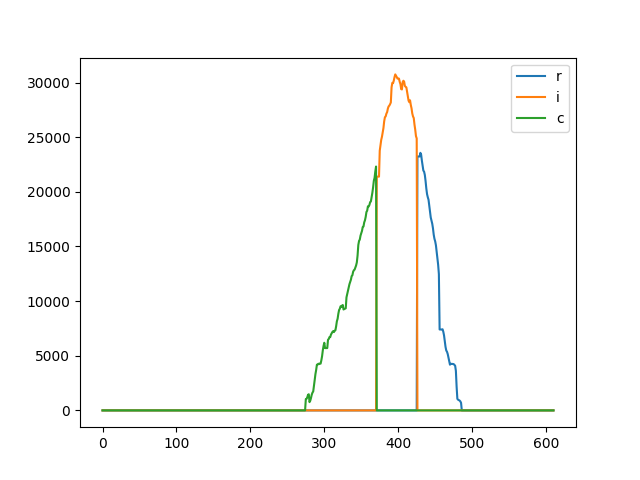

In [17]:
fig,ax = plt.subplots()
ax.plot(np.sum(Srostral>0,axis=(0,2,3)),label='r')
ax.plot(np.sum(Sintermediate>0,axis=(0,2,3)),label='i')
ax.plot(np.sum(Scaudal>0,axis=(0,2,3)),label='c')
ax.legend()

In [18]:
# TODO
# add one more level down the tree

def generate_region_mask(S, regionID):
    self_and_children = list(descendents_and_self[regionID])
    region_mask = np.zeros_like(S)
    for i in self_and_children:
        region_mask = np.logical_or(region_mask, S==i)
    return region_mask

# === Striatum Dorsal Region (STRd) ===

# CP regions
Scpr_m   = generate_region_mask(S,2294)
Scpr_imd = generate_region_mask(S,2295)
Scpr_imv = generate_region_mask(S,2296)
Scpr_l   = generate_region_mask(S,2497)
Scpi_dm  = generate_region_mask(S,2498)
Scpi_vm  = generate_region_mask(S,2500)
Scpi_dl  = generate_region_mask(S,2499)
Scpi_vl  = generate_region_mask(S,2501)
Scpc_d   = generate_region_mask(S,2493)
Scpc_i   = generate_region_mask(S,2494)
Scpc_v   = generate_region_mask(S,2490)

# Non-CP regions
S_lss = generate_region_mask(S,2001)
S_ast = generate_region_mask(S,2050)

# === Striatum Ventral Region (STRv) ===
S_acb  = generate_region_mask(S,56)  # Accumbens nucleus
S_ipac = generate_region_mask(S,998) # Interstitial nucleus of the posterior limb of the anterior commissure
S_tu   = generate_region_mask(S,754) # Olfactory tubercle

# === (10/3/23) Striatum adjacent regions ===
S_lsx = generate_region_mask(S,275)  # Lateral septal complex
S_samy = generate_region_mask(S,278) # Striatum-like amygdalar nuclei
S_pal = generate_region_mask(S,803)  # Pallidum

# === (10/4/23) Striatum adjacent regions ===
S_lv =   generate_region_mask(S,81)  # Lateral ventricle
S_cc =   generate_region_mask(S,776) # Corpus callosum
S_cl =   generate_region_mask(S,583) # Claustrum
S_en =   generate_region_mask(S,942) # Endopiriform nucleus
S_pir =  generate_region_mask(S,961) # Piriform nucleus
S_ic =   generate_region_mask(S,6)   # Internal capsule
S_mfbc = generate_region_mask(S,768) # Cerebrum related (fiber tracts)

In [19]:
print(f'N (Scp): {np.sum(Scp):,}')
print(f'N (Scpr): {np.sum(Srostral):,}')
print(f'N (Scpi): {np.sum(Sintermediate):,}')
print(f'N (Scpc): {np.sum(Scaudal):,}')

print(f'N (Scpr_m): {np.sum(Scpr_m):,}')
print(f'N (Scpr_imd): {np.sum(Scpr_imd):,}')
print(f'N (Scpr_imv): {np.sum(Scpr_imv):,}')
print(f'N (Scpr_l): {np.sum(Scpr_l):,}')

print(f'N (Scpi_dm): {np.sum(Scpi_dm):,}')
print(f'N (Scpi_vm): {np.sum(Scpi_vm):,}')
print(f'N (Scpi_dl): {np.sum(Scpi_dl):,}')
print(f'N (Scpi_vl): {np.sum(Scpi_vl):,}')

print(f'N (Scpc_d): {np.sum(Scpc_d):,}')
print(f'N (Scpc_i): {np.sum(Scpc_i):,}')
print(f'N (Scpc_v): {np.sum(Scpc_v):,}')

print(f'N (S_lss): {np.sum(S_lss):,}')
print(f'N (S_ast): {np.sum(S_ast):,}')

print(f'N (S_acb): {np.sum(S_acb):,}')
print(f'N (S_ipac): {np.sum(S_ipac):,}')
print(f'N (S_tu): {np.sum(S_tu):,}')

print(f'N (S_lsx): {np.sum(S_lsx):,}')
print(f'N (S_samy): {np.sum(S_samy):,}')
print(f'N (S_pal): {np.sum(S_pal):,}')

print(f'N (S_lv): {np.sum(S_lv):,}')
print(f'N (S_cc): {np.sum(S_cc):,}')
print(f'N (S_cl): {np.sum(S_cl):,}')
print(f'N (S_en): {np.sum(S_en):,}')
print(f'N (S_pir): {np.sum(S_pir):,}')
print(f'N (S_ic): {np.sum(S_ic):,}')
print(f'N (S_mfbc): {np.sum(S_mfbc):,}')


N (Scp): 3,229,761
N (Scpr): 706,051
N (Scpi): 1,520,835
N (Scpc): 958,160
N (Scpr_m): 70,819
N (Scpr_imd): 99,533
N (Scpr_imv): 111,221
N (Scpr_l): 291,109
N (Scpi_dm): 421,650
N (Scpi_vm): 225,215
N (Scpi_dl): 255,682
N (Scpi_vl): 618,288
N (Scpc_d): 256,855
N (Scpc_i): 425,212
N (Scpc_v): 197,721
N (S_lss): 11,946
N (S_ast): 32,769
N (S_acb): 602,895
N (S_ipac): 127,466
N (S_tu): 565,446
N (S_lsx): 546,346
N (S_samy): 428,806
N (S_pal): 1,235,621
N (S_lv): 487,202
N (S_cc): 1,276,390
N (S_cl): 100,992
N (S_en): 432,277
N (S_pir): 1,653,666
N (S_ic): 336,168
N (S_mfbc): 922,256


In [20]:
# I think what I'd like to do is assign a gaussian to each region
# then give the neurons a distribution based on the Gaussian
# to do this I should load a set of neurons
# and also start visualizing

# what I think would make sense is to take all the cp structures
# blur them a lot
# then assign probabilities
# we also want to look at the neurons though

In [21]:
# i want to start by visualizing
# we need to load swc files
# and we need to contour the surfaces
d = [x[1] - x[0] for x in xS]


In [22]:
down = 16
xSd,Scpd = emlddmm.downmode(xS,Scp[0],down=[down,down,down])

/home/dtward/data/csh_data/emlddmm/emlddmm.py:642: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  S_ = mode(S_,axis=0)[0][0]


In [23]:
dd = [x[1] - x[0] for x in xSd]

In [24]:
verts,faces,normals,values = marching_cubes(Scpd,level=0.5,spacing=dd)
verts = verts + np.array([x[0] for x in xSd])

## Load SWC files and Display 2x2 figure

In [25]:
# swcdir = '../swc_out_v08' # this is tme07
# swcdir = '../dragonfly_tme09-1/swc_out_v08'
# swcdir = '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs'

brain = 'TME08-1'
swcdir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs'
files = glob(join(swcdir,'*.swc'))
files = [f for f in files if 'permuted' not in f]
files

['/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/126_TME08-1_30x_Str_03B_x10703_y19209_z262_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/196_TME08-1_30x_Str_05A_x4192_y8886_z266_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/070_TME08-1_30x_Str_03A_x10604_y9246_z388_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/089_TME08-1_30x_Str_03A_x13329_y15236_z146_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/124_TME08-1_30x_Str_03B_x10385_y16980_z320_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/177_TME08-1_30x_Str_04B_x2128_y17866_z324_30x-Mapped_mapped.swc',
 '/home/abenneck/dragonfly_work/dragonfly_outputs/TME08-1/dragonfly_joint_outputs/115_TME08-1_30x_Str_03A_x904

In [26]:
x = []
for file in files:
    with open(file)  as f:
        for i,line in enumerate(f):    
            print(line)
            if 'Tward' in line:                
                continue
            else:
                if ',' in line:
                    lim = ','
                else:
                    lim = ''
                coords = [float(c) for c in line.split(lim)[2:5]]                
                    
                x.append(coords)
                break
    
            
x = np.array(x)            
            

1,2300,1328.0889892578125,2608.678466796875,-680.62841796875,1.0,-1

1,2488,495.3385314941406,-3338.443115234375,356.34027099609375,1.0,-1

1,2480,1477.179931640625,-1645.1002197265625,1376.7991943359375,1.0,-1

1,2298,1579.8460693359375,-984.1388549804688,129.13670349121094,1.0,-1

1,2301,1281.9105224609375,2552.017333984375,-229.89537048339844,1.0,-1

1,2298,1144.537109375,-1370.9609375,-284.64617919921875,1.0,-1

1,2370,1297.4906005859375,-1872.260986328125,173.1656036376953,1.0,-1

1,2374,1187.6600341796875,1920.769287109375,-330.65057373046875,1.0,-1

1,2395,2094.85302734375,2063.670654296875,175.0404815673828,1.0,-1

1,2301,1097.849609375,-2654.733154296875,-519.853515625,1.0,-1

1,2481,1488.9447021484375,2671.3388671875,1694.0078125,1.0,-1

1,551,395.98638916015625,-2699.689453125,1395.7049560546875,1.0,-1

1,2300,1767.120849609375,-2061.90478515625,-580.3322143554688,1.0,-1

1,2380,991.870361328125,1603.720458984375,-1317.2366943359375,1.0,-1

1,2050,-614.72607421875,-3283.2338

### Generate + Save figure

Text(0.5, 0.98, 'TME08-1')

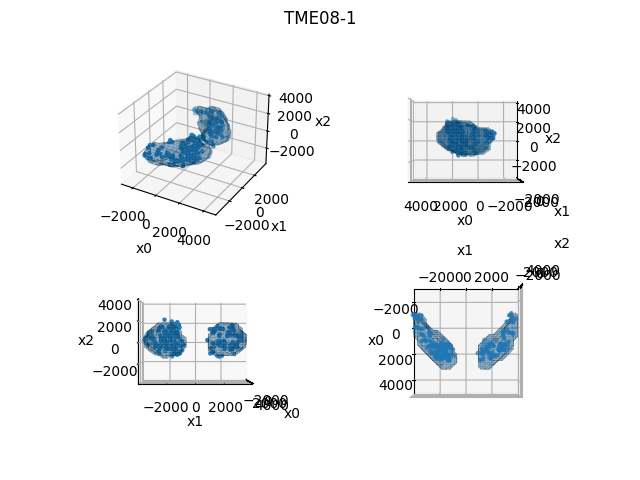

In [27]:
s = 5
alpha = 0.25
lw = 0.25


mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
fig = plt.figure()
ax = fig.add_subplot(2,2,1,projection='3d')
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)


ax = fig.add_subplot(2,2,2,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,90)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,3,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(0,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)



ax = fig.add_subplot(2,2,4,projection='3d')
mesh = Poly3DCollection(verts[faces],ec=[0.0,0.0,0.0,0.1],lw=lw,alpha=alpha,)
ax.view_init(90,0)
ax.add_collection3d(mesh)
# set limits uniform
vertsmin = np.min(verts,0)
vertsmax = np.max(verts,0)
vertsc = vertsmin*0.5 + vertsmax*0.5
vertsd = vertsmax-vertsmin
vertsd = np.max(vertsd)
lim = vertsc[None] + np.array([-1,1])[...,None]/2*vertsd
ax.set_xlim(lim[:,0])
ax.set_ylim(lim[:,1])
ax.set_zlim(lim[:,2])
ax.set_xlabel('x0')
ax.set_ylabel('x1')
ax.set_zlabel('x2')
ax.scatter(x[:,0],x[:,1],x[:,2],s=s)

# fig.suptitle(swcdir.split('/')[-2])
# fig.savefig('CP_SWC_QC_figure_'+swcdir.split('/')[-2]+'.jpg')

fig.suptitle(f'{brain}')
# fig.savefig(join(f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/',f'CP_SWC_QC_figure_{brain}.jpg'))

In [28]:
# raise Exception(f'End of QC figure generation for {brain}')

In [29]:
# so what is a plan going forward
# I'd like to take every blob as a gaussian
# the height is its volume
# the mean is its mean
# the covariance is its covariance
# the only trouble here is the left right issue
# another posiblility is to just blur the labels
# this may get rid of small structures though
# but I could give less blur to the small structures

In [30]:
# first going forward
# 1. make a figure like this to get a sense of the uncertainty for each brain
# 2. make a probabilitistic version of the CP structures.
# I'd like to model each structure as a gaussian blob (ellispoids with soft boundaries)
# this needs three parameters
# the mean (a 3 element vector)
# the covariance (3x3 symmetric matrix)
# and the height/amplitude of the gaussian (one positive number)

# The height (amplitude) should be the number of voxels in the structure
# the mean, is going to be the first moment of the segmentation
# the covariance, is the second central moment of the segmentation.

### Compute + Save Gaussian parameters for CP

In [31]:
def generate_gaussian_param(subregion_mask, hemi, fname):
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere
    
    # ===== Compute Gaussian parameters =====
    
    # number of voxels in 'subregion'
    Ncp = np.sum(subregion_mask*LR_indicator)
    # print(f'number of voxels {Ncp}')
    
    # note xS tells us the location of each voxel
    # let's compute the first moment
    mucp = [np.sum(xS[0][:,None,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[1][:,None]*subregion_mask*LR_indicator)/Ncp, np.sum(xS[2][:]*subregion_mask*LR_indicator)/Ncp]
    # print(f'mu {mucp}')
    
    # now calculate the covariance matrix
    covcp01 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[1][:,None] - mucp[1])*subregion_mask*LR_indicator)/Ncp # here row 0 column 1
    covcp02 = np.sum((xS[0][:,None,None] - mucp[0])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 0 column 2
    covcp12 = np.sum((xS[1][None,:,None] - mucp[1])*(xS[2][None,:] - mucp[2])*subregion_mask*LR_indicator)/Ncp # here row 1 column 2
    
    covcp00 = np.sum(((xS[0][:,None,None] - mucp[0])**2)*subregion_mask*LR_indicator)/Ncp # here row 0 column 0
    covcp11 = np.sum(((xS[1][None,:,None] - mucp[1])**2)*subregion_mask*LR_indicator)/Ncp # here row 1 column 1
    covcp22 = np.sum(((xS[2][None,None,:] - mucp[2])**2)*subregion_mask*LR_indicator)/Ncp # here row 2 column 2
    
    covcp = [[covcp00,covcp01,covcp02],[covcp01,covcp11,covcp12],[covcp02,covcp12,covcp22]]
    
    # print('cov:')
    # print(f'{covcp[0]}')
    # print(f'{covcp[1]}')
    # print(f'{covcp[2]}')
    
    # Save Gaussian parameters in.npz file with keys [height, mu, cov]
    save_path = join('/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
    np.savez(save_path,height=[Ncp],mu=mucp,cov=covcp)
    print(f'Saved {fname}\n')

# ===== Specify subregion and hemisphere =====
genParam = False
if genParam:
    for hemi in ['L','R']:
        generate_gaussian_param(Scp, hemi,f'cp_param_{hemi}.npz')
        generate_gaussian_param(Srostral, hemi,f'cpr_param_{hemi}.npz')
        generate_gaussian_param(Sintermediate, hemi,f'cpi_param_{hemi}.npz')
        generate_gaussian_param(Scaudal, hemi,f'cpc_param_{hemi}.npz')
        
        generate_gaussian_param(Scpr_m, hemi,f'cpr_m_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imd, hemi,f'cpr_imd_param_{hemi}.npz')
        generate_gaussian_param(Scpr_imv, hemi,f'cpr_imv_param_{hemi}.npz')
        generate_gaussian_param(Scpr_l, hemi,f'cpr_l_param_{hemi}.npz')
        
        generate_gaussian_param(Scpi_dm, hemi,f'cpi_dm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vm, hemi,f'cpi_vm_param_{hemi}.npz')
        generate_gaussian_param(Scpi_dl, hemi,f'cpi_dl_param_{hemi}.npz')
        generate_gaussian_param(Scpi_vl, hemi,f'cpi_vl_param_{hemi}.npz')
        
        generate_gaussian_param(Scpc_d, hemi,f'cpc_d_param_{hemi}.npz')
        generate_gaussian_param(Scpc_i, hemi,f'cpc_i_param_{hemi}.npz')
        generate_gaussian_param(Scpc_v, hemi,f'cpc_v_param_{hemi}.npz')

        generate_gaussian_param(S_lss, hemi, f'lss_param_{hemi}.npz')
        generate_gaussian_param(S_ast, hemi, f'ast_param_{hemi}.npz')
        
        generate_gaussian_param(S_acb, hemi, f'acb_param_{hemi}.npz')
        generate_gaussian_param(S_ipac, hemi, f'ipac_param_{hemi}.npz')
        generate_gaussian_param(S_tu, hemi, f'tu_param_{hemi}.npz')
        
        generate_gaussian_param(S_lsx, hemi, f'lsx_param_{hemi}.npz')
        generate_gaussian_param(S_samy, hemi, f'samy_param_{hemi}.npz')
        generate_gaussian_param(S_pal, hemi, f'pal_param_{hemi}.npz')
        
        generate_gaussian_param(S_lv, hemi,f'lv_param_{hemi}.npz')
        generate_gaussian_param(S_cc, hemi,f'cc_param_{hemi}.npz')
        generate_gaussian_param(S_cl, hemi,f'cl_param_{hemi}.npz')
        generate_gaussian_param(S_en, hemi,f'en_param_{hemi}.npz')
        generate_gaussian_param(S_pir, hemi,f'pir_param_{hemi}.npz')
        generate_gaussian_param(S_ic, hemi,f'ic_param_{hemi}.npz')
        generate_gaussian_param(S_mfbc, hemi,f'mfbc_param_{hemi}.npz')

### Load Gaussian parameters given hemi and subregion

In [32]:
# hemi = 'L'
hemi = 'R'
subregion = ''

fname = f'cpc_v_param_{hemi}.npz'
fpath = join(f'/home/abenneck/dragonfly_work/gaussian_parameters/',fname)
out = np.load(fpath)

h = out['height'][0]
mu = out['mu']
cov = out['cov']

print(f'Displating parameters for {fname};\n')
print(f'height: {h}')
print(f'mu: {mu}')
print(f'cov: {cov}')

Displating parameters for cpc_v_param_R.npz;

height: 98845
mu: [ 394.72375942 3143.2739137  1075.84389701]
cov: [[123992.11677122 -29055.38829264  19248.51805967]
 [-29055.38829264  79812.81631632 -31988.42170582]
 [ 19248.51805967 -31988.42170582  75230.84760312]]


In [33]:
# once we have parameters for each gaussian
# then we can evalute them at every point in space
# so for a given cell body, we can find a distribution over this number of regions
# for each level of the tree, you can get a distribution over all the structures in that level
# start with R-I-C level
# TODO, come up with some measure of concordance
#   that is related to nick's labels, but allows some slop

In [34]:
# we don't really believe the uncertaint is given by the voxel size (we're not getting 1 voxel accurate registration)
# we believe it is related to the anatomy

### Compute distance transform for each mask

In [35]:
from scipy.ndimage import distance_transform_edt
import time

def generateDistanceTransform(xS, mask, hemi, fname, save_path = '', scale_factor = 10):
    start = time.time()
    if hemi == 'R':
        LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
    else:
        LR_indicator = (xS[1][:,None]<0)  # Left hemisphere

    if save_path == '':
        save_path = '/home/abenneck/dragonfly_work/distance_parameters/'

    transformedMask = np.exp(-distance_transform_edt(1-mask*LR_indicator)/scale_factor)
    # transformedMask[transformedMask == 1.0] = 0.0
    transformedMask = transformedMask / np.sum(transformedMask)
    
    # Save distance transform parameters in .npz file with keys [mask]
    save_path = join(save_path,fname)
    np.savez(save_path, mask = transformedMask.astype(np.float32))
    print(f'Saved {fname} after {time.time() - start : .2f} s')
    
    return transformedMask

saveDistanceParam = False
if saveDistanceParam:
    for hemi in ['L','R']:
        generateDistanceTransform(xS, Scp, hemi, f'cp_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Srostral, hemi, f'cpr_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Sintermediate, hemi, f'cpi_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scaudal, hemi, f'cpc_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpr_m, hemi, f'cpr_m_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imd, hemi, f'cpr_imd_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_imv, hemi, f'cpr_imv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpr_l, hemi, f'cpr_l_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpi_dm, hemi, f'cpi_dm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vm, hemi, f'cpi_vm_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_dl, hemi, f'cpi_dl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpi_vl, hemi, f'cpi_vl_dist_param_{hemi}.npz')
    
        generateDistanceTransform(xS, Scpc_d, hemi, f'cpc_d_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_i, hemi, f'cpc_i_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, Scpc_v, hemi, f'cpc_v_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_lss, hemi, f'lss_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_ast, hemi, f'ast_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_acb, hemi, f'acb_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_ipac, hemi, f'ipac_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_tu, hemi, f'tu_dist_param_{hemi}.npz')
        
        generateDistanceTransform(xS, S_lsx, hemi, f'lsx_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_samy, hemi, f'samy_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pal, hemi, f'pal_dist_param_{hemi}.npz')

        generateDistanceTransform(xS, S_lv, hemi, f'lv_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_cc, hemi, f'cc_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_cl, hemi, f'cl_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_en, hemi, f'en_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_pir, hemi, f'pir_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_ic, hemi, f'ic_dist_param_{hemi}.npz')
        generateDistanceTransform(xS, S_mfbc, hemi, f'mfbc_dist_param_{hemi}.npz')

### Load dist param

In [36]:
out = np.load('/home/abenneck/dragonfly_work/distance_parameters/cp_dist_param_L.npz')
out = out['mask']

x, y, z = 100, 100, -100

print(out[0, x, y, z])

6.3741224e-15


In [122]:
get_coord_list(672, XS, S) # 672 is regionID for CP

[array([ 2590., -2130.,   -70.]),
 array([ 2590., -2130.,   -50.]),
 array([ 2590., -2130.,   -30.]),
 array([ 2590., -2130.,   -10.]),
 array([ 2590., -2130.,    10.]),
 array([ 2590., -2130.,    30.]),
 array([ 2590., -2130.,    50.]),
 array([ 2590., -2130.,    70.]),
 array([ 2590., -2130.,    90.]),
 array([ 2590., -2110.,  -130.]),
 array([ 2590., -2110.,  -110.]),
 array([ 2590., -2110.,   -90.]),
 array([ 2590., -2110.,   -70.]),
 array([ 2590., -2110.,   -50.]),
 array([ 2590., -2110.,   -30.]),
 array([ 2590., -2110.,   -10.]),
 array([ 2590., -2110.,    10.]),
 array([ 2590., -2110.,    30.]),
 array([ 2590., -2110.,    50.]),
 array([ 2590., -2110.,    70.]),
 array([ 2590., -2110.,    90.]),
 array([ 2590., -2110.,   110.]),
 array([ 2590., -2110.,   130.]),
 array([ 2590., -2110.,   150.]),
 array([ 2590., -2110.,   170.]),
 array([ 2590., -2090.,  -190.]),
 array([ 2590., -2090.,  -170.]),
 array([ 2590., -2090.,  -150.]),
 array([ 2590., -2090.,  -130.]),
 array([ 2590.

In [121]:
def L1_filter_gauss(fileName):
    if len(fileName) <= 15 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def L2_filter_gauss(fileName):
    if len(fileName) > 15 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def non_CP_filter_gauss(fileName):
    if not L2_filter_gauss(fileName) and not L1_filter_gauss(fileName) and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def L1_filter_dist(fileName):
    if len(fileName) <= 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def L2_filter_dist(fileName):
    if len(fileName) > 21 and fileName != '.ipynb_checkpoints' and 'cp' in fileName:
        return True
    else:
        return False

def non_CP_filter_dist(fileName):
    if not L2_filter_dist(fileName) and not L1_filter_dist(fileName) and fileName != '.ipynb_checkpoints':
        return True
    else:
        return False

def get_coord_list(region_id, XS, S):
    self_and_children = list(descendents_and_self[region_id])
    allCoords = list()
    for idNum in self_and_children:
        regionCoords = XS[S[0]==idNum]
        if len(regionCoords) != 0:
            for coord in regionCoords:
                allCoords.append(coord)
    return allCoords

# Distance with vectorization
def dist_from_cp(allCoords, soma_location, useForLoop = False):
    if useForLoop:
        minDist = -1
        for c in allCoords:
            distance = math.dist(c,soma_location)
            if minDist == -1 or minDist > distance:
                minDist = distance
        return minDist        
    else:
        # out = allCoords-soma_location => [allCoords[0]-soma_location, allCoords[1]-soma_location, ...]
        # out = (out)**2                => Square all terms within out
        # out = np.sum(out, axis=1)     => [out[0][0]+out[0][1]+out[0][2], out[1][0]+out[1][1]+out[1][2], ...]
        # out = np.sqrt(out)            => sqrt all terms within out
        # out = np.min(out)             => min of all distances
        return np.min(np.sqrt(np.sum((allCoords-soma_location)**2, axis=1)))

# Round neuron coord to nearest atlas coord
def roundCoord(sub_xS, coord):
    if coord < np.min(sub_xS):
        coord = np.min(sub_xS)
    elif coord > np.max(sub_xS):
        coord = np.max(sub_xS)
    else:
        coord_rounded = 20*round(coord/20) # Round coordinate to nearest 20
        if coord < 0:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
        else:
            if coord - coord_rounded >= 0:
                coord = coord_rounded + 10
            else:
                coord = coord_rounded - 10
    return coord

# Absolute probabilities => (Normalize probabilities at multiple levels) => Conditional probabilities
def normalize_prob(allProb):    
    L0_labels = ['CP_L','CP_R','ACB0_L','ACB0_R']
    allProb[L0_labels] = allProb[L0_labels].div(np.sum(allProb[L0_labels], axis=1), axis=0)

    L1_labels = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R','ACB1_L','ACB1_R']
    allProb[L1_labels] = allProb[L1_labels].div(np.sum(allProb[L1_labels], axis=1), axis=0)
    
    L2_labels = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R','ACB2_L','ACB2_R']
    allProb[L2_labels] = allProb[L2_labels].div(np.sum(allProb[L2_labels], axis=1), axis=0)

    nonCP_labels = ['ACB_L','ACB_R','AST_L','AST_R','CC_L','CC_R','CL_L','CL_R','EN_L','EN_R','IC_L','IC_R','IPAC_L','IPAC_R','LSS_L','LSS_R','LSX_L','LSX_R','LV_L','LV_R','MFBC_L','MFBC_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R','TU_L','TU_R']
    allProb[nonCP_labels] = allProb[nonCP_labels].div(np.sum(allProb[nonCP_labels], axis=1), axis=0)

    return allProb

In [38]:
hemi = 'R'

if hemi == 'R':
    LR_indicator = (xS[1][:,None]>=0) # Right hemisphere
else:
    LR_indicator = (xS[1][:,None]<0)  # Left hemisphere

# Define idx and coord values for the CP (For debugging purposes)
cp_idx_x = np.unique(np.where(Scp[0] == 1)[0])
cp_coords_x = xS[0][cp_idx_x]

cp_idx_y = np.unique(np.where(Scp[0]*LR_indicator == 1)[1])
cp_coords_y = xS[1][cp_idx_y]
# print(cp_coords_y)

cp_idx_z = np.unique(np.where(Scp[0] == 1)[2])
cp_coords_z = xS[2][cp_idx_z]

In [123]:
# brains = ['TME07-1', 'TME08-1', 'TME09-1', 'TME10-1', 'TME10-3', 'TME12-1']
brains = ['TME08-1']

allRegionCoords = get_coord_list(672, XS, S) # 672 is regionID for CP
allRegionCoords = np.asarray(allRegionCoords)
uniform_prior = 1/100

print('Loading regional amplitudes')
start = time.time()
# Create list of priors from presaved parameters
paramDir = '/home/abenneck/dragonfly_work/gaussian_parameters'
L1_files = sorted(filter(L1_filter_gauss,os.listdir(paramDir)))
L2_files = sorted(filter(L2_filter_gauss,os.listdir(paramDir)))
nonCP_files = sorted(filter(non_CP_filter_gauss,os.listdir(paramDir)))
allPriors = list()
for fileList in [L1_files, L2_files, nonCP_files]:
    for file in fileList:
        data = np.load(os.path.join(paramDir,file))
        norm_factor = data['height'].item()
        allPriors.append(norm_factor)
print(f'Finished loading amp in {time.time() - start} s\n')

print('Loading distance transform distributions')
start = time.time()
# Create list of distributions from presaved distance transforms
# paramDir = '/home/abenneck/dragonfly_work/distance_parameters'
paramDir = '/home/abenneck/dragonfly_work/distance_parameters'
L1_files = sorted(filter(L1_filter_dist,os.listdir(paramDir)))
L2_files = sorted(filter(L2_filter_dist,os.listdir(paramDir)))
nonCP_files = sorted(filter(non_CP_filter_dist,os.listdir(paramDir)))
allTransforms = list()
for fileList in [L1_files, L2_files, nonCP_files]:
    for file in fileList:
        data = np.load(os.path.join(paramDir,file))
        probDist = data['mask']
        allTransforms.append(probDist)
print(f'Finished loading distributions in {time.time() - start} s\n')

# if True:
#     raise Exception('Rewrite some of the below code')

print('Generating probabilities')
start = time.time()
# Generate probabilities
for brain in brains:
    # Define relevant directories
    neuronDir = f'/home/abenneck/dragonfly_work/dragonfly_outputs/{brain}/dragonfly_joint_outputs/'

    # Note: The ACB#_x columns are inserted after computing absolute probabilities, but before normalization
    L0_col = ['mouse ID', 'slice', 'hemi', 'neuron ID','dist (CP)','fname','CP_L','CP_R']
    L1_col = ['CPc_L','CPc_R','CPi_L','CPi_R','CPr_L','CPr_R',]
    L2_col = ['CPc_d_L','CPc_d_R','CPc_i_L','CPc_i_R','CPc_v_L','CPc_v_R','CPi_dl_L','CPi_dl_R','CPi_dm_L','CPi_dm_R','CPi_vl_L','CPi_vl_R','CPi_vm_L','CPi_vm_R','CPr_imd_L','CPr_imd_R','CPr_imv_L','CPr_imv_R','CPr_l_L','CPr_l_R','CPr_m_L','CPr_m_R']
    nonCP_col = ['ACB_L','ACB_R','AST_L','AST_R','CC_L','CC_R','CL_L','CL_R','EN_L','EN_R','IC_L','IC_R','IPAC_L','IPAC_R','LSS_L','LSS_R','LSX_L','LSX_R','LV_L','LV_R','MFBC_L','MFBC_R','PAL_L','PAL_R','PIR_L','PIR_R','SAMY_L','SAMY_R','TU_L','TU_R']
    allCol = np.concatenate([L0_col, L1_col, L2_col, nonCP_col])
    allProb = pd.DataFrame(columns=allCol)
    
    # Generate regional probabilities for every neuron in neuronDir
    row_idx = 0
    for i, file in enumerate(sorted(os.listdir(neuronDir))):
        if "mapped.swc" in file:
            # Load soma coordinates
            data = pd.read_csv(os.path.join(neuronDir,file))
            x = float(data.columns[2])
            y = float(data.columns[3])
            z = float(data.columns[4])
            soma_location = [x,y,z]

            # Get idx for soma location in xS
            x_ind = np.where(xS[0] == roundCoord(xS[0], x))[0].item()
            y_ind = np.where(xS[1] == roundCoord(xS[1], y))[0].item() 
            z_ind = np.where(xS[2] == roundCoord(xS[2], z))[0].item()

            # Get metadata from filename
            mouseID = file.split('_')[1]
            sliceID = file.split('_')[4][:-1]
            hemiID = file.split('_')[4][-1]
            neuronID = file.split('_')[0]
    
            # Compute probabilities from distance transform probabilities
            cpDist = dist_from_cp(allRegionCoords,soma_location)
            neuronProb = [mouseID, sliceID, hemiID, neuronID, cpDist, file]
            for j, prior in enumerate(allPriors):
                neuronProb.append(uniform_prior*allTransforms[j][0, x_ind, y_ind, z_ind])

            allProb.loc[row_idx] = neuronProb
            row_idx+=1
            print(f'{i}/{len(sorted(os.listdir(neuronDir)))} Finished {file}\n')

    # Insert ACB at each level
    allProb.insert(allProb.columns.get_loc('CP_R')+1,'ACB0_L',allProb['ACB_L'])
    allProb.insert(allProb.columns.get_loc('ACB0_L')+1,'ACB0_R',allProb['ACB_R'])
    
    allProb.insert(allProb.columns.get_loc('CPr_R')+1,'ACB1_L',allProb['ACB_L'])
    allProb.insert(allProb.columns.get_loc('ACB1_L')+1,'ACB1_R',allProb['ACB_R'])
    
    allProb.insert(allProb.columns.get_loc('CPr_m_R')+1,'ACB2_L',allProb['ACB_L'])
    allProb.insert(allProb.columns.get_loc('ACB2_L')+1,'ACB2_R',allProb['ACB_R'])

    # Normalize probabilities at each level
    allProb = normalize_prob(allProb)

    # Save probability distributions as one .csv file in tempDir
    tempDir = f'/home/abenneck/dragonfly_work/{brain}_neuron_region_prob.csv'   
    allProb.to_csv(tempDir, index=False)

    print(f'Finished {brain} in {time.time() - start} s with an average of {(time.time() - start) / len(allProb)} s / neuron\n')

Loading regional amplitudes
Finished loading amp in 0.04440188407897949 s

Loading distance transform distributions
Finished loading distributions in 75.5126383304596 s

Generating probabilities
idx (x,y,z) = (423,311,139)
Pre (x,y,z) = (1936.7197265625,1076.3502197265625,-1057.384033203125)
Post (x,y,z) = (1930,1070,-1050)
1/658 Finished 001_TME08-1_30x_Str_02A_x10345_y19733_z278_30x-Mapped_mapped.swc

idx (x,y,z) = (445,309,256)
Pre (x,y,z) = (2361.91015625,1038.3529052734375,1288.74658203125)
Post (x,y,z) = (2370,1030,1290)
3/658 Finished 003_TME08-1_30x_Str_02A_x11130_y7923_z439_30x-Mapped_mapped.swc

idx (x,y,z) = (421,301,204)
Pre (x,y,z) = (1882.0919189453125,860.1048583984375,240.08956909179688)
Post (x,y,z) = (1890,870,250)
5/658 Finished 004_TME08-1_30x_Str_02A_x11587_y12677_z155_30x-Mapped_mapped.swc

idx (x,y,z) = (428,372,224)
Pre (x,y,z) = (2039.820068359375,2294.851318359375,645.5777587890625)
Post (x,y,z) = (2030,2290,650)
7/658 Finished 005_TME08-1_30x_Str_02A_x4061_y1

In [115]:
data = pd.read_csv('/home/abenneck/dragonfly_work/TME08-1_neuron_region_prob.csv')



In [ ]:
# # Create list of multivariate Gaussian RVs from presaved parameters
# allDist = list()
# for fileList in [L1_files, L2_files]:
#     for file in fileList:
#         data = np.load(os.path.join(paramDir,file))
#         norm_factor = data['height'].item()
#         mu = data['mu']
#         cov = data['cov']
#         regionDist = multivariate_normal(mean=mu, cov=cov, allow_singular=False)
#         # regionDist = 
#         allDist.append([regionDist,norm_factor])

In [ ]:
# tempDir = f'/home/abenneck/dragonfly_work/{brain}_neuron_region_prob_test2.csv'

# allProb.to_csv(tempDir, index=False)

In [ ]:
# pd.set_option('display.max_columns', None)